<a href="https://colab.research.google.com/github/yanghang0918/EPEX-Thesis/blob/Final/EPEX-Thesis/Aggregated%20Contract%20Analysis/Aggregated_ID_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple
from neuralforecast.models import NBEATSx
from neuralforecast import NeuralForecast
from pandas.tseries.frequencies import to_offset
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from neuralforecast.losses.pytorch import MAE, SMAPE
import torch

import warnings
warnings.filterwarnings("ignore")

In [3]:

import torch
print(torch.__version__)
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [ ]:
!pip install neuralforecast

# Data Preprocessing

In [2]:
df_train = pd.read_parquet('train_fullyears.parquet')
test_2024 = pd.read_parquet('test_2024.parquet')
df_variables = pd.read_parquet('df_train_variables.parquet')
df_test_variables = pd.read_parquet('df_test_variables.parquet')
df_full_variables = pd.concat([df_variables, df_test_variables])

df_train['ExecutionTime'] = df_train['ExecutionTime'].dt.tz_localize(None)
test_2024['ExecutionTime'] = test_2024['ExecutionTime'].dt.tz_localize(None)

In [3]:
def get_delivery_time(df):
    df['weekday_num'] = df['ExecutionTime'].dt.weekday
    df['ID_weekday_num'] = df['ID'].str[:3]
    df['ID_weekday_num'] = df['ID_weekday_num'].replace({'Mon':0, 'Tue':1, 'Wed':2,
                                                         'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6})
    df['days_to_add'] = (df['ID_weekday_num'] - df['weekday_num'])%7
    df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(df['days_to_add'],unit='d')
    hours = df['ID'].str[3:5].astype(int)
    minutes = ((df['ID'].str[-1].astype(int) - 1) * 15)
    df['delivery_time'] = pd.to_datetime(df['delivery_date']) + pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')
    df = df.drop(columns=['weekday_num','ID_weekday_num','days_to_add','delivery_date'])

    return df


def enrich_contract_panel(df: pd.DataFrame):
    df = df.copy()
    df['delivery_time'] = pd.to_datetime(df['delivery_time'])
    df['ExecutionTime']  = pd.to_datetime(df['ExecutionTime'])
    df.sort_values(['delivery_time', 'ExecutionTime'], inplace=True)

    df['delivery_hour']  = df['delivery_time'].dt.floor('h')
    df['minute_in_hour'] = df['delivery_time'].dt.minute  # 0/15/30/45
    df['price_range'] = df['high'] - df['low']

    key = ['delivery_hour', 'ExecutionTime']
    gx  = df.groupby(key, sort=False)
    df['q2h_price_diff']  = df['close']  - gx['close'].transform('mean')
    df['q2h_volume_diff'] = df['volume'] - gx['volume'].transform('mean')

    drop_cols = ['delivery_hour','minute_in_hour']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

    return df

def merge_variables(df, df_variables):
    df_variables['wind_forecast'] = df_variables['generation_wind_onshore_forecast'] + df_variables['generation_wind_offshore_forecast']
    df_variables = df_variables.rename(columns={"generation_solar_forecast":"solar_forecast"})
    print(f"before merge: {df.shape}")
    df = df.merge(df_variables, on='delivery_time', how='left')
    print(f"after merge: {df.shape}")

    return df

def remove_outliers(df: pd.DataFrame, cols, drop_cols=('close',)):
    """
    For each col in `cols`:
      - compute the 99th percentile of absolute values
      - if col in `drop_cols`: drop rows where |col| > threshold
      - else: clip to [-threshold, +threshold]
    Returns cleaned df and thresholds dict.
    """
    df_clean = df.copy()
    before = df_clean['delivery_time'].nunique()

    mask = pd.Series(True, index=df_clean.index)

    thresholds = {}
    for col in cols:
        # skip non-numeric columns safely
        if not pd.api.types.is_numeric_dtype(df_clean[col]):
            continue
        thr = np.percentile(np.abs(df_clean[col].dropna()), 99)
        thresholds[col] = thr

        if col in drop_cols:
            # mark rows to keep for this column
            mask &= (np.abs(df_clean[col]) <= thr)
        else:
            # clip (no row removal)
            df_clean[col] = df_clean[col].clip(lower=-thr, upper=thr)

    # apply dropping once at the end (affects all columns consistently)
    df_clean = df_clean[mask]

    after = df_clean['delivery_time'].nunique()
    print(f"before remove outlier {before}")
    print(f"after remove outlier  {after}")

    return df_clean


def fill_gaps(df, full_range):
    ids = df["ID"].drop_duplicates().sort_values()
    frame_full = pd.MultiIndex.from_product(
        [ids, full_range], names=["ID", "ExecutionTime"]
    ).to_frame(index=False)
    out = frame_full.merge(df, on=["ID", "ExecutionTime"], how="left")

    return out


def add_temproal_features(df):
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['delivery_time'].dt.dayofyear  / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['delivery_time'].dt.dayofyear / 365)
    df['delivery_hour'] = df['delivery_time'].dt.hour
    df['delivery_hour_sin'] = np.sin(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_hour_cos'] = np.cos(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_weekday_sin'] = np.sin(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_weekday_cos'] = np.cos(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_month_sin'] = np.sin(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['delivery_month_cos'] = np.cos(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['time_to_expiry_h'] = (df['delivery_time'] - df['ExecutionTime']).dt.total_seconds() / 3600.0
    df['qh_sin'] = np.sin(2 * np.pi * (df['delivery_time'].dt.hour * 4 + df['delivery_time'].dt.minute // 15) / 96)
    df['qh_cos'] = np.cos(2 * np.pi * (df['delivery_time'].dt.hour * 4 + df['delivery_time'].dt.minute // 15) / 96)

    return df


def check_timestamp_completeness(df, freq=None):
    step = to_offset(freq)
    g = (df
         .drop_duplicates(['delivery_time','ExecutionTime'])
         .sort_values(['delivery_time','ExecutionTime'])
         .groupby('delivery_time', as_index=False))

    agg = g.agg(start=('ExecutionTime','min'),
                end=('ExecutionTime','max'),
                rows=('ExecutionTime','count'))

    exp = ((agg['end'] - agg['start']) / pd.to_timedelta(step.nanos, unit='ns')).astype(int) + 1
    agg['expected'] = exp
    agg['missing'] = agg['expected'] - agg['rows']
    agg['missing_ratio'] = agg['missing'] / agg['expected']
    agg['has_gap'] = agg['missing'] > 0

    return agg.sort_values('missing', ascending=False)


def filter_complete_ids(df: pd.DataFrame, completeness_df: pd.DataFrame):
    print(f"before continutiy check: {df['delivery_time'].nunique()}")
    ok_ids = completeness_df.loc[~completeness_df['has_gap'], 'delivery_time']
    df = df[df['delivery_time'].isin(ok_ids)].copy()
    print(f"after continutiy check: {df['delivery_time'].nunique()}")
    return df

def preprocess(df, df_variables, train=True):
    df= df[df['ExecutionTime'].dt.minute.eq(0) & df['ExecutionTime'].dt.second.eq(0)].reset_index(drop=True)
    value_cols = [c for c in df.columns if c not in ['ID', 'ExecutionTime','delivery_time','delivery_date']]
    df = (df.groupby(['ID', 'ExecutionTime'], as_index=False)[value_cols].mean())
    df = get_delivery_time(df)
    print(f"delivery_time amounts: {df['delivery_time'].nunique()}")
    # add external features:
        # 1. q2h difference on price and volume
    df = enrich_contract_panel(df)
    print(f'columns: {len(df.columns)}')
        # 2. lws forecast
        # 3. tempreture t-1d
        # 4. imported, exported forecast
    df = merge_variables(df, df_variables=df_variables)
    # remove outliers -99 percentile
    if train == True:
        df = remove_outliers(df, df.columns)
    # filter out the lack hour continutiy contract
    report = check_timestamp_completeness(df, freq="1H")
    df = filter_complete_ids(df, report)
    # add one column indentifying the war and post-covind period
    df['special_period'] = ( df['ExecutionTime'].between('2021-01-01', '2021-03-31') | df['ExecutionTime'].between('2022-02-24', '2022-12-31')).astype(int)
    return df, report

In [4]:
def plot_kde_subplots(df: pd.DataFrame, cols=None, cols_per_row=5, figsize_per_plot=(4, 3)):

    # choose numeric columns
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    if cols is not None:
        # keep only numeric + requested intersection, preserve order in cols
        numeric_cols = [c for c in cols if c in numeric_cols]
    if not numeric_cols:
        raise ValueError("No numeric columns to plot.")

    n = len(numeric_cols)
    rows = math.ceil(n / cols_per_row)
    fig_w = figsize_per_plot[0] * cols_per_row
    fig_h = figsize_per_plot[1] * rows

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(fig_w, fig_h), squeeze=False)

    for i, col in enumerate(numeric_cols):
        r, c = divmod(i, cols_per_row)
        ax = axes[r][c]
        df[col].dropna().plot(kind="kde", ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.grid(True, alpha=0.3)

    # hide any unused axes
    for j in range(n, rows * cols_per_row):
        r, c = divmod(j, cols_per_row)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()


In [5]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mad_cols=(), sparse_cols=(), passthrough_cols=()):
        self.mad_cols = list(mad_cols)
        self.sparse_cols = list(sparse_cols)  # will get indicator + arcsinh
        self.passthrough_cols = list(passthrough_cols)

        # fitted stats
        self.mad_median_ = None
        self.mad_scale_ = None
        self.sparse_median_ = None
        self.sparse_scale_ = None
        self.robust_cols_ = None
        self.robust_median_ = None
        self.robust_scale_ = None
        self.feature_names_in_ = None

    @staticmethod
    def _nanmedian(x, axis=0):
        return np.nanmedian(x, axis=axis)

    @staticmethod
    def _nanquantile(x, q, axis=0):
        return np.nanquantile(x, q, axis=axis)

    def fit(self, X, y=None):
        X = X.copy()
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        self.robust_cols_ = [
            c for c in numeric_cols
            if c not in self.mad_cols
            and c not in self.sparse_cols
            and c not in self.passthrough_cols
        ]

        # ---- stats for MAD columns ----
        if self.mad_cols:
            A = X[self.mad_cols].to_numpy(dtype=float)
            med = np.nanmedian(A, axis=0)
            mad_raw = np.nanmedian(np.abs(A - med), axis=0)
            c75 = 0.67448975
            scale = mad_raw / c75
            scale = np.where((~np.isfinite(scale)) | (scale == 0), 1.0, scale)
            self.mad_median_ = med
            self.mad_scale_ = scale

        # ---- stats for sparse cols (nonzero values only) ----
        if self.sparse_cols:
            A = X[self.sparse_cols].to_numpy(dtype=float)
            A[A == 0] = np.nan  # ignore zeros when fitting
            med = np.nanmedian(A, axis=0)
            mad_raw = np.nanmedian(np.abs(A - med), axis=0)
            c75 = 0.67448975
            scale = mad_raw / c75
            scale = np.where((~np.isfinite(scale)) | (scale == 0), 1.0, scale)
            self.sparse_median_ = med
            self.sparse_scale_ = scale

        # ---- stats for IQR robust cols ----
        if self.robust_cols_:
            R = X[self.robust_cols_].to_numpy(dtype=float)
            med_r = np.nanmedian(R, axis=0)
            q25 = np.nanquantile(R, 0.25, axis=0)
            q75 = np.nanquantile(R, 0.75, axis=0)
            iqr = q75 - q25
            iqr = np.where((~np.isfinite(iqr)) | (iqr == 0), 1.0, iqr)
            self.robust_median_ = med_r
            self.robust_scale_ = iqr

        return self

    def transform(self, X):
        X = X.copy()

        # ---- MAD + arcsinh ----
        if self.mad_cols:
            A = X[self.mad_cols].to_numpy(dtype=float)
            Z = (A - self.mad_median_) / self.mad_scale_
            X[self.mad_cols] = np.arcsinh(Z)

        # ---- sparse cols: add indicator + transform nonzeros ----
        if self.sparse_cols:
            A = X[self.sparse_cols].to_numpy(dtype=float)
            for i, col in enumerate(self.sparse_cols):
                # indicator
                X[f"has_{col}"] = (A[:, i] != 0).astype(int)
                # transform only nonzeros
                nonzero_mask = A[:, i] != 0
                Z = (A[:, i] - self.sparse_median_[i]) / self.sparse_scale_[i]
                Z = np.arcsinh(Z)
                Z[~nonzero_mask] = 0  # keep zeros
                X[col] = Z

        # ---- robust cols ----
        if self.robust_cols_:
            R = X[self.robust_cols_].to_numpy(dtype=float)
            Zr = (R - self.robust_median_) / self.robust_scale_
            X[self.robust_cols_] = Zr

        return X

    def get_feature_names_out(self, input_features=None):
        # passthrough + mad + sparse (with has_) + robust
        extra = [f"has_{c}" for c in self.sparse_cols]
        return np.concatenate([self.feature_names_in_, extra])


In [6]:
def fill_gaps(df, full_range):
    ids = df["ID"].drop_duplicates().sort_values()
    frame_full = pd.MultiIndex.from_product(
        [ids, full_range], names=["ID", "ExecutionTime"]
    ).to_frame(index=False)
    out = frame_full.merge(df, on=["ID", "ExecutionTime"], how="left")
    return out

def add_temproal_features(df):
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['delivery_time'].dt.dayofyear  / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['delivery_time'].dt.dayofyear / 365)
    df['delivery_hour'] = df['delivery_time'].dt.hour
    df['delivery_hour_sin'] = np.sin(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_hour_cos'] = np.cos(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_weekday_sin'] = np.sin(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_weekday_cos'] = np.cos(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_month_sin'] = np.sin(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['delivery_month_cos'] = np.cos(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['time_to_expiry_h'] = (df['delivery_time'] - df['ExecutionTime']).dt.total_seconds() / 3600.0
    df['qh_sin'] = np.sin(2 * np.pi * (df['delivery_time'].dt.hour * 4 + df['delivery_time'].dt.minute // 15) / 96)
    df['qh_cos'] = np.cos(2 * np.pi * (df['delivery_time'].dt.hour * 4 + df['delivery_time'].dt.minute // 15) / 96)
    return df

def get_delivery_time(df):
    df['weekday_num'] = df['ExecutionTime'].dt.weekday
    df['ID_weekday_num'] = df['ID'].str[:3]
    df['ID_weekday_num'] = df['ID_weekday_num'].replace({'Mon':0, 'Tue':1, 'Wed':2,
                                                         'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6})
    df['days_to_add'] = (df['ID_weekday_num'] - df['weekday_num'])%7
    df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(df['days_to_add'],unit='d')
    hours = df['ID'].str[3:5].astype(int)
    minutes = ((df['ID'].str[-1].astype(int) - 1) * 15)
    df['delivery_time'] = pd.to_datetime(df['delivery_date']) + pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')
    df = df.drop(columns=['weekday_num','ID_weekday_num','days_to_add','delivery_date'])
    return df

def rename_df(df):
    df = df.rename(columns={"ExecutionTime": "ds", "ID":"unique_id", "close": "y"})
    df = df[['unique_id', 'ds', 'y', 'high', 'low', 'volume', 'price_range', 'q2h_price_diff', 'q2h_volume_diff', 'day_ahead_price',
              'load_forecast', 'solar_forecast', 'wind_forecast', 'temperature_rounded','imported', 'exported',
              'day_of_year_sin', 'day_of_year_cos' ,'delivery_month_sin',
              'delivery_month_cos','time_to_expiry_h', 'special_period', 'delivery_hour_sin', 'delivery_hour_cos', 'delivery_weekday_sin',
              'delivery_weekday_cos','qh_sin', 'qh_cos',
              'has_imported', 'has_exported', 'has_volume', 'has_q2h_volume_diff']]
    df["has_data"] = (~df["high"].isnull()).astype(int)
    return df


In [9]:
train, r_train = preprocess(df_train, df_variables)
test,r_test = preprocess(test_2024, df_test_variables, train=False)

delivery_time amounts: 103963
columns: 10
before merge: (2040286, 10)
after merge: (2040286, 26)
before remove outlier 103963
after remove outlier  103571
before continutiy check: 103571
after continutiy check: 101851
delivery_time amounts: 21895
columns: 10
before merge: (429793, 10)
after merge: (429793, 26)
before continutiy check: 21895
after continutiy check: 21634


before scaling: 


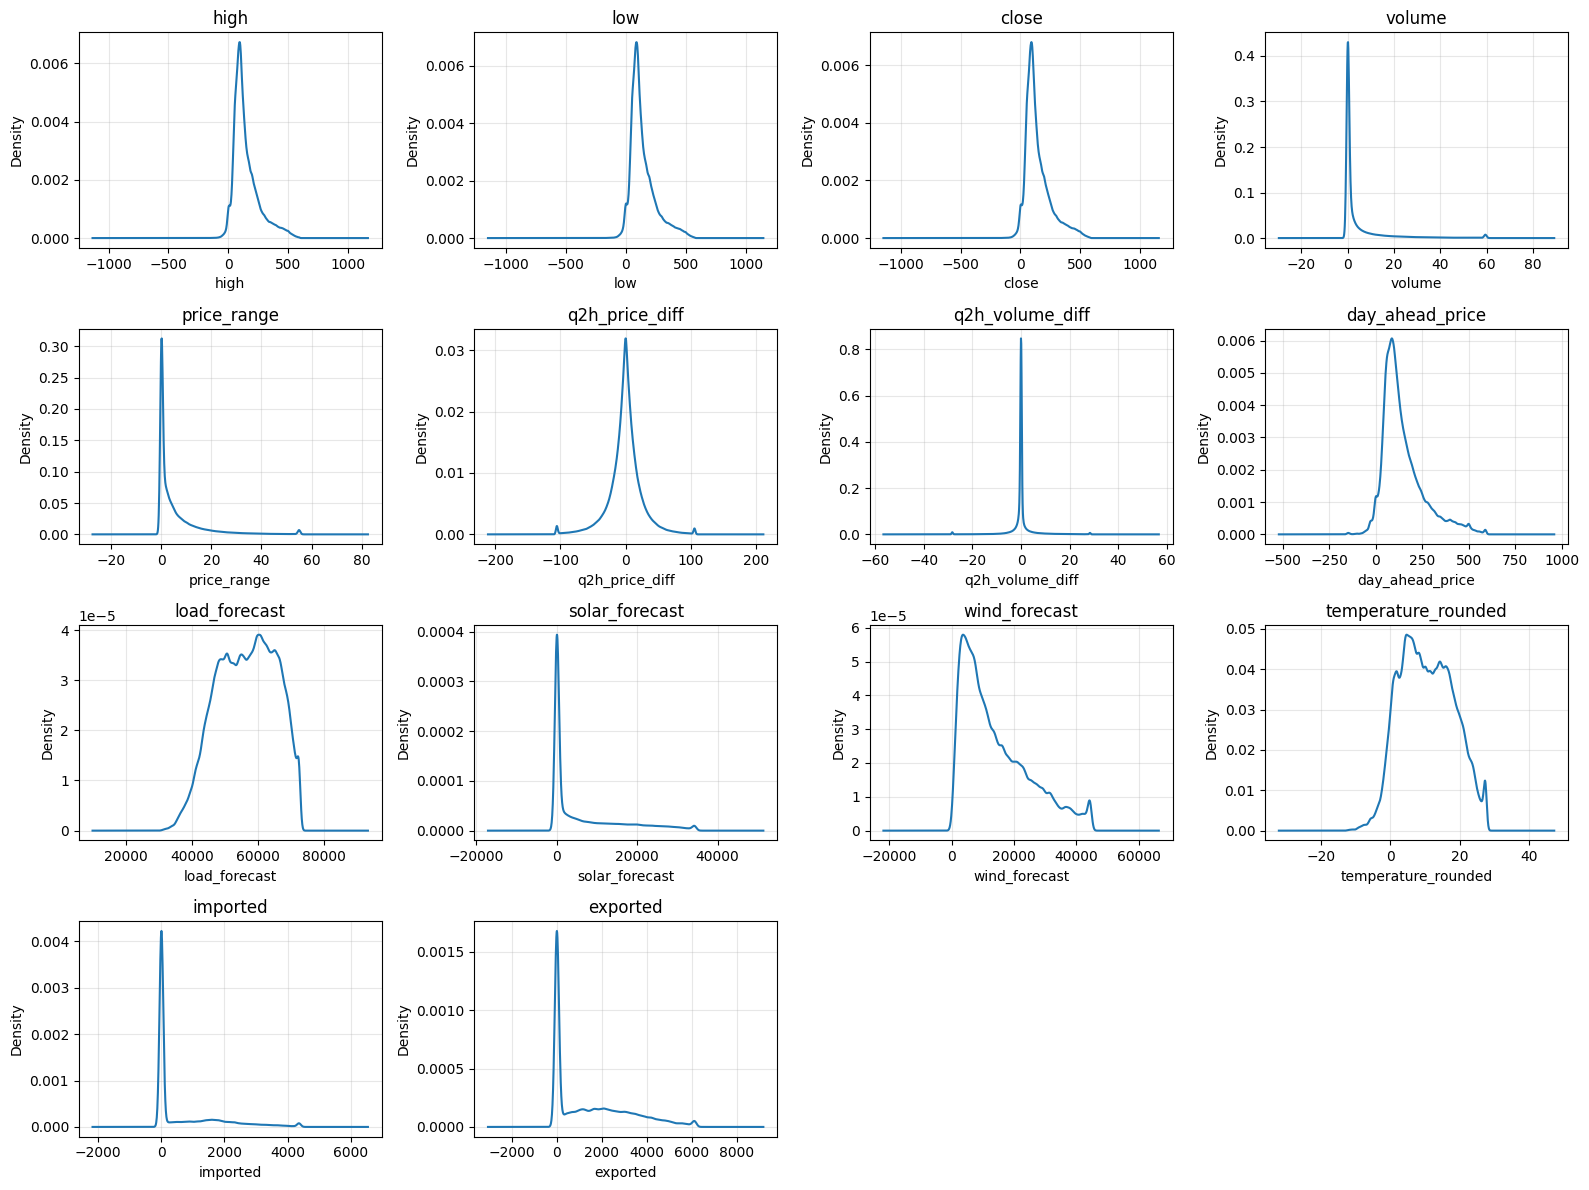

In [14]:
print(f"before scaling: ")
cols = ['high', 'low', 'close', 'volume', 'price_range', 'q2h_price_diff', 'q2h_volume_diff','day_ahead_price', 'load_forecast',
        'solar_forecast', 'wind_forecast','temperature_rounded', 'imported', 'exported', 'time_to_expiry_h' ]
plot_kde_subplots(train, cols=cols, cols_per_row=4)


In [15]:
# scale
scaler = CustomScaler(
    mad_cols=["close","high","low","day_ahead_price","price_range","q2h_price_diff"],
    sparse_cols=["imported","exported","volume","q2h_volume_diff"],
    passthrough_cols=['ExecutionTime','ID','delvery_time']
)

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

after scaling: 


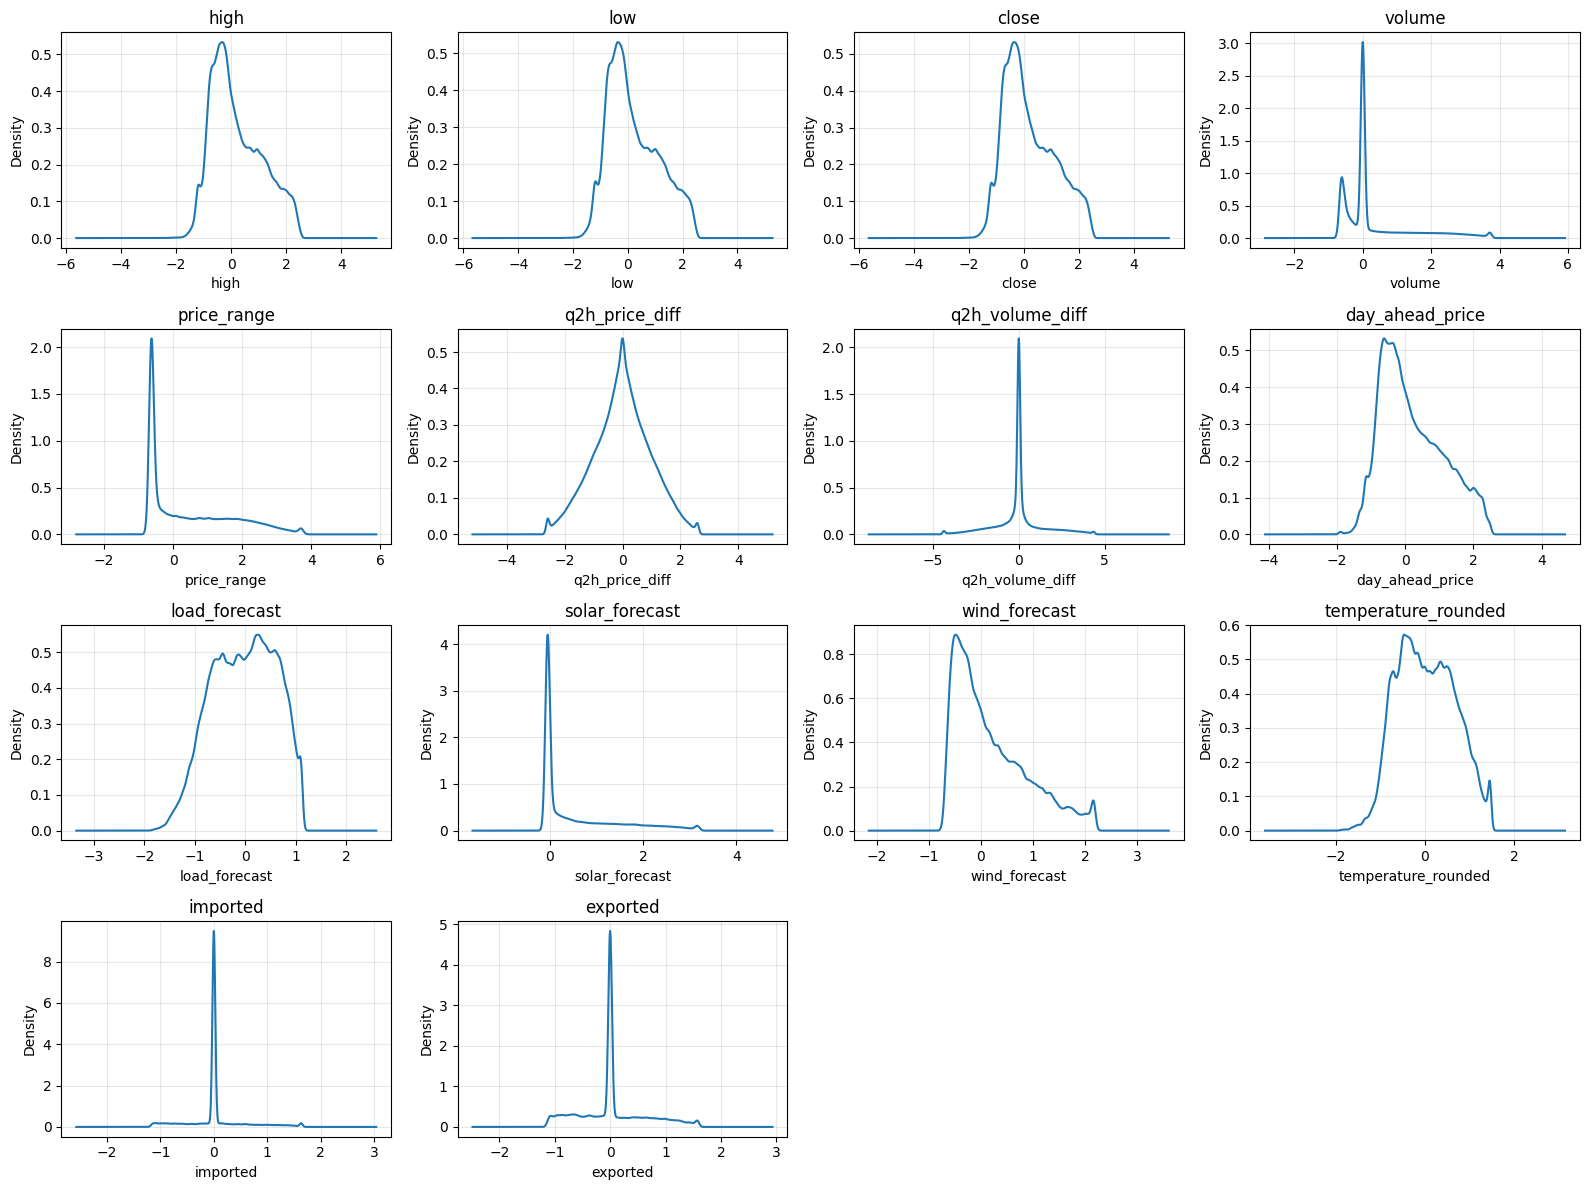

In [16]:
print(f"after scaling: ")
cols = ['high', 'low', 'close', 'volume', 'price_range', 'q2h_price_diff', 'q2h_volume_diff','day_ahead_price', 'load_forecast',
        'solar_forecast', 'wind_forecast','temperature_rounded', 'imported', 'exported', 'time_to_expiry_h' ]
plot_kde_subplots(train_scaled, cols=cols, cols_per_row=4)


In [17]:
full_range_train = pd.date_range("2021-01-01 00:00:00", "2024-01-06 20:00:00", freq="H")
full_range_test = pd.date_range("2024-01-06 21:00:00", "2024-08-31 23:00:00", freq="H")
train_scaled = fill_gaps(train_scaled, full_range_train) # (5886720, 40)
test_scaled = fill_gaps(test_scaled, full_range_test) #(3935232, 40)

In [18]:
train_scaled = get_delivery_time(train_scaled)
test_scaled = get_delivery_time(test_scaled)

In [19]:
train_scaled = add_temproal_features(train_scaled)
test_scaled = add_temproal_features(test_scaled)

In [20]:
train_final = rename_df(train_scaled)
test_final = rename_df(test_scaled)

In [21]:
test_actual = test[['ID','ExecutionTime','close','delivery_time']]

# NbeatsX

In [22]:
def evaluation(df, df_raw,  median = 113.35,
  scale = 74.04115481):

  Z = np.sinh(df.iloc[:,-1].to_numpy(dtype=float))
  x = Z * scale + median
  df[f"y_pred"] = x
  df_result = df_raw.merge(df, on=['unique_id','ds'],how='inner')
  y_true = df_result["y"].to_numpy()
  y_pred = df_result["y_pred"].to_numpy()

  # SMAPE
  smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
  # MAE
  mae = np.mean(np.abs(y_pred - y_true))
  # RMSE
  rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

  print(f"smape: {smape}")
  print(f"mae: {mae}")
  print(f"rmse: {rmse}")

  return df_result

In [23]:
def evaluation_plot(df):
  df = df.copy()
  df['ds'] = pd.to_datetime(df['ds'])
  df['delivery_time'] = pd.to_datetime(df['delivery_time'])

  df['time_to_expiry_h'] = (df['delivery_time'] - df['ds']).dt.total_seconds() / 3600.0
  eps = 1e-8
  df['smape'] = 200.0 * np.abs(df['y_pred'] - df['y']) / (np.abs(df['y_pred']) + np.abs(df['y']) + eps)

  # Plot: x=time_to_expiry_h, y=sMAPE (scatter) + binned mean line (by hour)
  fig, ax = plt.subplots(figsize=(12,3))
  ax.scatter(df['time_to_expiry_h'], df['smape'], s=6, alpha=0.3)
  # binned mean by integer hour
  bin_mean = (df
              .assign(tte_h_int=np.floor(df['time_to_expiry_h']).astype(int))
              .groupby('tte_h_int')['smape']
              .mean()
              .reset_index())
  ax.plot(bin_mean['tte_h_int'], bin_mean['smape'])
  ax.set_xlabel('Time to expiry (hours)')
  ax.set_ylabel('sMAPE (%)')
  ax.set_title('sMAPE vs. time-to-expiry')

  # Plot: group by delivery hour-of-day
  df['delivery_hour'] = df['delivery_time'].dt.hour
  by_hour = df.groupby('delivery_hour')['smape'].mean().reset_index()

  fig, ax = plt.subplots(figsize=(12,3))
  ax.plot(by_hour['delivery_hour'], by_hour['smape'], marker='o')
  ax.set_xticks(range(0,24))
  ax.set_xlabel('Delivery hour (0–23)')
  ax.set_ylabel('sMAPE (%)')
  ax.set_title('sMAPE by delivery hour')
  plt.show()

  # weekday
  df['delivery_weekday'] = df['delivery_time'].dt.weekday
  by_weekday = df.groupby('delivery_weekday')['smape'].mean().reset_index()

  fig, ax = plt.subplots(figsize=(12,3))
  ax.plot(by_weekday['delivery_weekday'], by_weekday['smape'], marker='o')
  ax.set_xlabel('Delivery weekday')
  ax.set_ylabel('sMAPE (%)')
  ax.set_title('sMAPE by delivery weekday')
  plt.show()

  # tte
  df['tti'] = df['time_to_expiry_h'].astype(int)
  by_tte = df.groupby('tti')['smape'].mean().reset_index()

  fig, ax = plt.subplots(figsize=(12,3))
  ax.plot(by_tte['tti'], by_tte['smape'], marker='o')
  ax.set_xlabel('time_to_expiry_h')
  ax.set_ylabel('sMAPE (%)')
  ax.set_title('sMAPE by time_to_expiry_h')
  plt.show()



In [24]:
def final_metric_comparison(nbeatsx_m):
  nbeatsx_m["smape"] = (200 * np.abs(nbeatsx_m["y_pred"] - nbeatsx_m["y"]) / (np.abs(nbeatsx_m["y"]) + np.abs(nbeatsx_m["y_pred"]) + 1e-8))
  nbeatsx_m["mae"] = np.abs(nbeatsx_m["y_pred"] - nbeatsx_m["y"])
  metrics_by_id = (
      nbeatsx_m.groupby("unique_id")[["smape", "mae"]]
      .mean()
      .reset_index())
  print(f"Average SMAPE: {nbeatsx_m['smape'].mean()}%")
  print(f"Min SMAPE: {metrics_by_id['smape'].min()}%")
  print(f"Max SMAPE: {metrics_by_id['smape'].max()}%")
  print(f"Median SMAPE: {metrics_by_id['smape'].median()}%")

  print(f"Average MAE: {nbeatsx_m['mae'].mean()}")
  print(f"Min MAE: {metrics_by_id['mae'].min()}")
  print(f"Max MAE: {metrics_by_id['mae'].max()}")
  print(f"Median MAE: {metrics_by_id['mae'].median()}")
  return nbeatsx_m, metrics_by_id

## Next 24 hours prediction

In [25]:
hist_cols = ['high', 'low', 'volume', 'price_range', 'q2h_price_diff', 'q2h_volume_diff', 'day_ahead_price',
              'load_forecast', 'solar_forecast', 'wind_forecast', 'temperature_rounded','imported', 'exported',
              'day_of_year_sin', 'day_of_year_cos' ,'delivery_month_sin', 'has_data',
              'delivery_month_cos','time_to_expiry_h', 'special_period', 'has_imported', 'has_exported', 'has_volume', 'has_q2h_volume_diff']

futr_cols = ['day_ahead_price','load_forecast', 'solar_forecast', 'wind_forecast', 'temperature_rounded','imported', 'exported',
              'day_of_year_sin', 'day_of_year_cos', 'delivery_month_sin', 'has_data',
              'delivery_month_cos','time_to_expiry_h', 'special_period', 'has_imported', 'has_exported', 'has_volume', 'has_q2h_volume_diff']

static_cols = ['delivery_hour_sin', 'delivery_hour_cos', 'delivery_weekday_sin', 'delivery_weekday_cos','qh_sin', 'qh_cos' ]

In [26]:
train_f = train_final.fillna(0)
test_f = test_final.fillna(0)

In [27]:
test_actual = test_actual.rename(columns={"ExecutionTime":"ds", "ID": "unique_id", "close":"y"})

In [28]:
static_train = train_f[['unique_id'] + static_cols].drop_duplicates('unique_id')
static_test  = test_f[['unique_id'] + static_cols].drop_duplicates('unique_id')

In [29]:
def train_nbeatsx(
    train_f,
    static_train=None,
    futr_cols= None,
    hist_cols= None,
    static_cols = None,
    h = 24,
    input_size= 168,
    freq = '1H',
    val_size = 168,
    stack_types = ["identity","trend","seasonality","exogenous"],
    n_blocks=[2,2,2,2],
    mlp_units=[[128,128],[128,128],[128,128],[128,128]],
    dropout = 0.17,
    batch_size = 64,
    lr= 2e-3,
    max_steps = 500,
    val_check_steps = 10,
    early_stop_patience_steps = None,
    step_size= 24,
    scaler_type = None,
):


    model = NBEATSx(
        h=h, input_size=input_size,
        stack_types=stack_types,
        n_blocks=n_blocks,
        mlp_units=mlp_units,
        dropout_prob_theta=dropout,
        futr_exog_list=futr_cols ,
        hist_exog_list=hist_cols ,
        stat_exog_list=static_cols ,
        batch_size=batch_size,
        learning_rate=lr,
        max_steps=max_steps,
        val_check_steps=val_check_steps,
        scaler_type=scaler_type,
        loss=MAE(),
        step_size=step_size,
    )

    nf = NeuralForecast(models=[model], freq=freq)
    nf.fit(df=train_f, val_size=val_size, static_df=static_train )
    return nf, model


In [30]:
nf_t, model = train_nbeatsx(
    train_f=train_f,
    static_train=static_train,
    futr_cols=futr_cols,
    hist_cols=hist_cols,
    static_cols=static_cols,
    h=24, input_size=168, val_size=168, freq='1H',
    stack_types = ["identity","trend","seasonality","exogenous"],
    n_blocks = [2,2,2,2],
    mlp_units = [[128,128],[128,128],[128,128],[128,128]],
    dropout= 0.17,
    batch_size= 64,
    lr = 2e-3,
    max_steps = 500,
    val_check_steps = 10,
    early_stop_patience_steps = 2,
    step_size = 24)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [31]:
X_test = test_f[['unique_id', 'ds']+futr_cols]
static_test  = test_f[['unique_id'] + static_cols].drop_duplicates('unique_id')
forecast_df = nf_t.predict(futr_df=X_test, static_df = static_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
nbeatsx_m = evaluation(forecast_df, test_actual)

smape: 10.822978082008197
mae: 10.161081868916012
rmse: 12.569987393453887


In [41]:
nbeatsx_m, nbeatsx_m_group = final_metric_comparison(nbeatsx_m)

Average SMAPE: 10.822978082008197%
Min SMAPE: 0.7706012086265707%
Max SMAPE: 66.26806364438356%
Median SMAPE: 9.862949715854839%
Average MAE: 10.161081868916012
Min MAE: 0.6716744094940452
Max MAE: 49.0829784184621
Median MAE: 9.233129831846128


<Axes: ylabel='Density'>

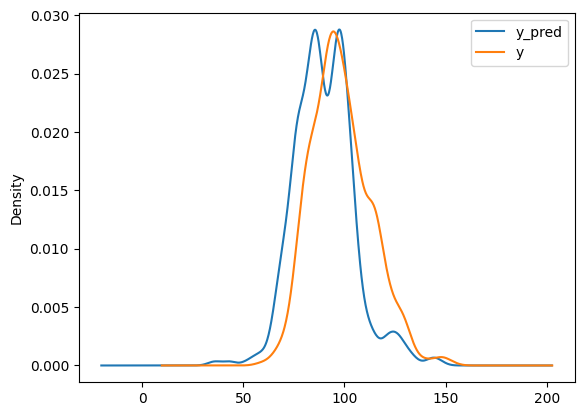

In [42]:
nbeatsx_m[['y_pred','y']].plot(kind='kde')

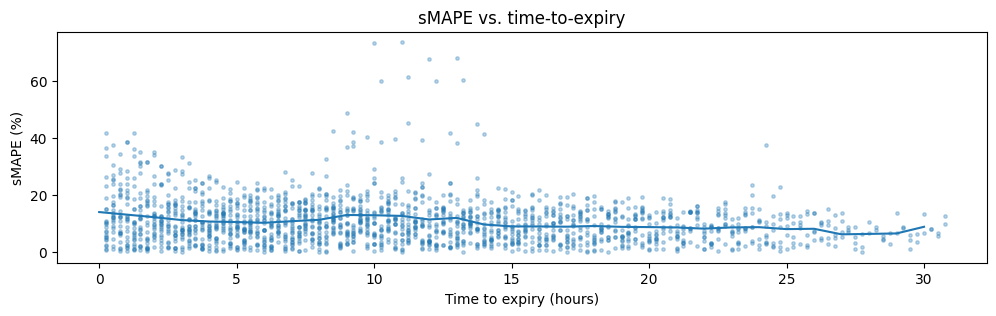

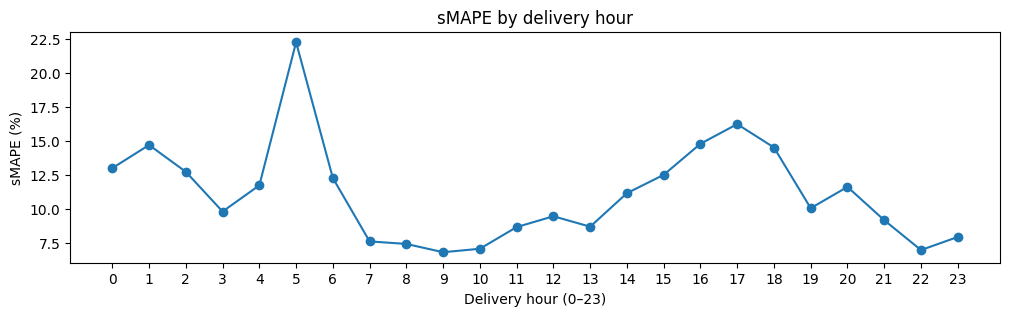

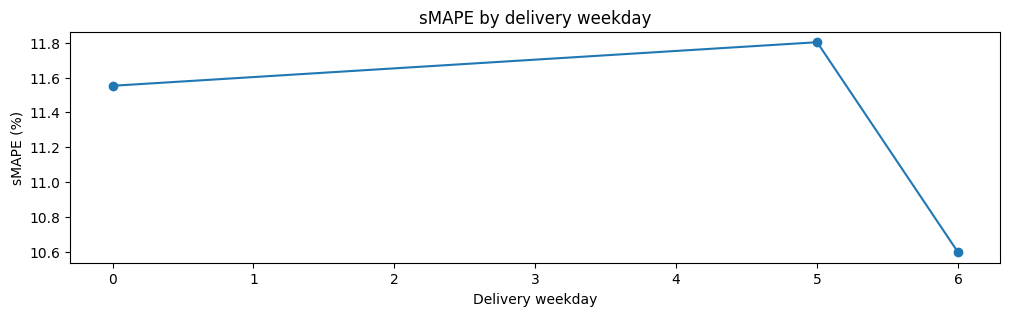

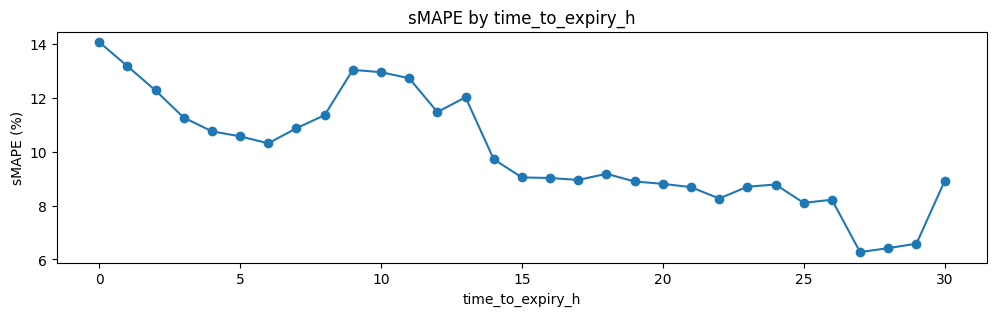

In [43]:
evaluation_plot(nbeatsx_m)

## Next hour prediction

In [44]:
nf_t_hour, model = train_nbeatsx(
    train_f=train_f,
    static_train=static_train,
    futr_cols=futr_cols,
    hist_cols=hist_cols,
    static_cols=static_cols,
    h=1, input_size=168, val_size=24, freq='1H',
    dropout=0.17, batch_size=64, lr=2e-3, max_steps=500,val_check_steps=10,
    stack_types=["identity"],
    n_blocks=[2],
    mlp_units=[[256,256]],
    step_size=24
)


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.9 M  | train
-------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.720    Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [45]:
forecast_df_hour = nf_t_hour.predict(futr_df=X_test, static_df = static_test)

/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/neuralforecast/core.py:940: UserWarning: Dropped 3,839,808 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [46]:
nbeatsx_m_hour = evaluation(forecast_df_hour, test_actual)

smape: 21.6827194148589
mae: 21.66182767868388
rmse: 23.990789630374667


In [47]:
nbeatsx_m_hour, nbeatsx_m_group_hour = final_metric_comparison(nbeatsx_m_hour)

Average SMAPE: 21.6827194148589%
Min SMAPE: 0.3503860525946932%
Max SMAPE: 42.53020641988222%
Median SMAPE: 20.63826853827902%
Average MAE: 21.66182767868388
Min MAE: 0.39649070910074613
Max MAE: 39.756490709100746
Median MAE: 21.206490709100734


In [ ]:
#nbeatsx_m_hour.to_parquet('nbeatsx_m_hour_result.parquet')

## Hyperparameter tuning on next 24 hours prediction



In [109]:
from ray import tune
from neuralforecast.auto import AutoNBEATSx

In [110]:
config={
    'step_size': 24,
    'val_check_steps': 10,
    "stack_types": ["identity", "trend", "seasonality", "exogenous"],
    'batch_size': tune.choice([64,128]),
    'input_size': tune.choice([168, 336]),
    "n_blocks": tune.choice([[2,2,2,2], [3,3,3,3]]),
    "mlp_units": tune.choice([
                [[64,64],[64,64],[64,64],[64,64]],
                [[128,128],[128,128],[128,128],[128,128],
                 [256, 256], [256,256], [256,256], [256, 256]]]),
    "dropout_prob_theta": tune.uniform(0.10, 0.30),
    "learning_rate": tune.loguniform(3e-4, 2e-3, 1e-5),
    "batch_size": tune.choice([32, 64, 128]),
    "early_stop_patience_steps": tune.choice([None, 8]),
    "futr_exog_list": futr_cols,
    "hist_exog_list": hist_cols,
    "stat_exog_list": static_cols,
    "futr_exog_list": futr_cols,
    "hist_exog_list": hist_cols,
    "stat_exog_list": static_cols,
    "scaler_type": None
}

In [111]:
auto = AutoNBEATSx(h=24,
                  loss=MAE(),
                  config=config,
                  num_samples=25 )

nf_auto = NeuralForecast(
    models=[auto],
    freq="1H"
)
nf_auto.fit(train_f, val_size=24, static_df=static_train)

2025-08-24 13:37:41,185	INFO worker.py:1927 -- Started a local Ray instance.
2025-08-24 13:37:46,832	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-08-24_13-37-36   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 25                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-08-24_13-37-36
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts`


(_train_tune pid=24289) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=24289) Seed set to 1
2025-08-24 13:37:59,862	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00000 errored after 0 iterations at 2025-08-24 13:37:59. Total running time: 12s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00000_0_batch_size=64,dropout_prob_theta=0.1288,early_stop_patience_steps=None,input_size=336,learning_rate=0.00_2025-08-24_13-37-47/error.txt


(_train_tune pid=24402) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=24402) Seed set to 1
(_train_tune pid=24402) GPU available: True (cuda), used: True
(_train_tune pid=24402) TPU available: False, using: 0 TPU cores
(_train_tune pid=24402) HPU available: False, using: 0 HPUs
(_train_tune pid=24402) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=24402) 2025-08-24 13:38:12.891432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/21 [00:00<?, ?it/s] 
(_train_tune pid=24402) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]
(_train_tune pid=24402) 
Validation DataLoader 0:  95%|█████████▌| 20/21 [00:01<00:00, 10.99it/s]
(_train_tune pid=24402) 
Epoch 0:  95%|█████████▌| 20/21 [00:04<00:00,  4.45it/s, v_num=0, train_loss_step=3.070, valid_loss=3.330]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=24402) 
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]
(_train_tune pid=24402) 
Validation DataLoader 0:  95%|█████████▌| 20/21 [00:01<00:00, 10.92it/s]
(_train_tune pid=24402) 
Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s, v_num=0, train_loss_step=2.630, valid_loss=1.600, train_loss_epoch=28.60]
(_train_tune pid=24402) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=24402) 
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?i

(_train_tune pid=24912) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=24912) Seed set to 1
2025-08-24 13:39:56,543	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00002 errored after 0 iterations at 2025-08-24 13:39:56. Total running time: 2min 9s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00002_2_batch_size=32,dropout_prob_theta=0.2076,early_stop_patience_steps=None,input_size=168,learning_rate=0.00_2025-08-24_13-37-47/error.txt


(_train_tune pid=25021) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=25021) Seed set to 1
2025-08-24 13:40:09,467	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00003 errored after 0 iterations at 2025-08-24 13:40:09. Total running time: 2min 22s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00003_3_batch_size=128,dropout_prob_theta=0.1268,early_stop_patience_steps=None,input_size=168,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=25133) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=25133) Seed set to 1
2025-08-24 13:40:22,482	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00004 errored after 0 iterations at 2025-08-24 13:40:22. Total running time: 2min 35s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00004_4_batch_size=128,dropout_prob_theta=0.2501,early_stop_patience_steps=None,input_size=168,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=25242) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=25242) Seed set to 1
(_train_tune pid=25242) GPU available: True (cuda), used: True
(_train_tune pid=25242) TPU available: False, using: 0 TPU cores
(_train_tune pid=25242) HPU available: False, using: 0 HPUs
(_train_tune pid=25242) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=25242) 2025-08-24 13:40:35.980795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


2025-08-24 13:40:39,297	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00005
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2858, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", li

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Trial _train_tune_75fab_00005 errored after 0 iterations at 2025-08-24 13:40:39. Total running time: 2min 52s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00005_5_batch_size=64,dropout_prob_theta=0.2450,early_stop_patience_steps=8,input_size=168,learning_rate=0.0008,_2025-08-24_13-37-47/error.txt


(_train_tune pid=25371) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=25371) Seed set to 1
2025-08-24 13:40:51,534	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00006
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00006 errored after 0 iterations at 2025-08-24 13:40:51. Total running time: 3min 4s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00006_6_batch_size=128,dropout_prob_theta=0.2940,early_stop_patience_steps=None,input_size=168,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=25480) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=25480) Seed set to 1
(_train_tune pid=25480) GPU available: True (cuda), used: True
(_train_tune pid=25480) TPU available: False, using: 0 TPU cores
(_train_tune pid=25480) HPU available: False, using: 0 HPUs
(_train_tune pid=25480) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=25480) 2025-08-24 13:41:04.942646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/21 [00:00<?, ?it/s] 
(_train_tune pid=25480) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]
(_train_tune pid=25480) 
Validation DataLoader 0:  95%|█████████▌| 20/21 [00:01<00:00, 10.70it/s]
(_train_tune pid=25480) 
Epoch 0:  95%|█████████▌| 20/21 [00:04<00:00,  4.27it/s, v_num=0, train_loss_step=6.760, valid_loss=5.940]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=25480) 
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]
(_train_tune pid=25480) 
Validation DataLoader 0:  95%|█████████▌| 20/21 [00:01<00:00, 10.70it/s]
(_train_tune pid=25480) 
Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s, v_num=0, train_loss_step=6.470, valid_loss=2.740, train_loss_epoch=48.70]
(_train_tune pid=25480) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=25480) 
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?i

(_train_tune pid=25900) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=25900) Seed set to 1
2025-08-24 13:42:30,546	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00008
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00008 errored after 0 iterations at 2025-08-24 13:42:30. Total running time: 4min 43s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00008_8_batch_size=64,dropout_prob_theta=0.1919,early_stop_patience_steps=None,input_size=168,learning_rate=0.00_2025-08-24_13-37-47/error.txt


(_train_tune pid=26012) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=26012) Seed set to 1
(_train_tune pid=26012) GPU available: True (cuda), used: True
(_train_tune pid=26012) TPU available: False, using: 0 TPU cores
(_train_tune pid=26012) HPU available: False, using: 0 HPUs
(_train_tune pid=26012) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=26012) 2025-08-24 13:42:44.027398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s] 
(_train_tune pid=26012) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=26012) 
Validation DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]
(_train_tune pid=26012) 
Validation DataLoader 0: 100%|██████████| 11/11 [00:01<00:00,  6.16it/s]
(_train_tune pid=26012) 
Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s, v_num=0, train_loss_step=75.80, valid_loss=14.50, train_loss_epoch=196.0]
(_train_tune pid=26012) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=26012) 
Validation DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]
(_train_tune pid=26012) 
Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s, v_num=0, train_loss_step=16.20, valid_loss=3.410, train_loss_epoch=35.10]
(_train_tune pid=26012) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=26012) 
Validation DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]
(_train_tune pid=26012) 
Epo

(_train_tune pid=26482) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=26482) Seed set to 1
(_train_tune pid=26482) GPU available: True (cuda), used: True
(_train_tune pid=26482) TPU available: False, using: 0 TPU cores
(_train_tune pid=26482) HPU available: False, using: 0 HPUs
(_train_tune pid=26482) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=26482) 2025-08-24 13:44:23.180958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


2025-08-24 13:44:26,338	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00010
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2858, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", li


Trial _train_tune_75fab_00010 errored after 0 iterations at 2025-08-24 13:44:26. Total running time: 6min 39s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00010_10_batch_size=64,dropout_prob_theta=0.2506,early_stop_patience_steps=8,input_size=336,learning_rate=0.0004_2025-08-24_13-37-47/error.txt


(_train_tune pid=26608) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=26608) Seed set to 1
(_train_tune pid=26608) GPU available: True (cuda), used: True
(_train_tune pid=26608) TPU available: False, using: 0 TPU cores
(_train_tune pid=26608) HPU available: False, using: 0 HPUs
(_train_tune pid=26608) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=26608) 2025-08-24 13:44:39.080172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


2025-08-24 13:44:42,708	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00011
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2858, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", li


Trial _train_tune_75fab_00011 errored after 0 iterations at 2025-08-24 13:44:42. Total running time: 6min 55s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00011_11_batch_size=128,dropout_prob_theta=0.1383,early_stop_patience_steps=8,input_size=168,learning_rate=0.001_2025-08-24_13-37-47/error.txt


(_train_tune pid=26741) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=26741) Seed set to 1
(_train_tune pid=26741) GPU available: True (cuda), used: True
(_train_tune pid=26741) TPU available: False, using: 0 TPU cores
(_train_tune pid=26741) HPU available: False, using: 0 HPUs
(_train_tune pid=26741) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=26741) 2025-08-24 13:44:55.999828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s] 
(_train_tune pid=26741) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=26741) 
Validation DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]
(_train_tune pid=26741) 
Validation DataLoader 0: 100%|██████████| 11/11 [00:01<00:00,  6.24it/s]
(_train_tune pid=26741) 
Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s, v_num=0, train_loss_step=23.20, valid_loss=6.400, train_loss_epoch=68.90]
(_train_tune pid=26741) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=26741) 
Validation DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]
(_train_tune pid=26741) 
Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s, v_num=0, train_loss_step=3.740, valid_loss=2.500, train_loss_epoch=9.690]
(_train_tune pid=26741) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=26741) 
Validation DataLoader 0:   0%|          | 0/11 [00:00<?, ?it/s]
(_train_tune pid=26741) 
Epo

(_train_tune pid=27137) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27137) Seed set to 1
2025-08-24 13:46:15,584	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00013
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00013 errored after 0 iterations at 2025-08-24 13:46:15. Total running time: 8min 28s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00013_13_batch_size=128,dropout_prob_theta=0.1014,early_stop_patience_steps=None,input_size=168,learning_rate=0._2025-08-24_13-37-47/error.txt


(_train_tune pid=27246) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27246) Seed set to 1
(_train_tune pid=27246) GPU available: True (cuda), used: True
(_train_tune pid=27246) TPU available: False, using: 0 TPU cores
(_train_tune pid=27246) HPU available: False, using: 0 HPUs
(_train_tune pid=27246) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=27246) 2025-08-24 13:46:29.053586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


2025-08-24 13:46:32,409	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00014
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2858, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", li


Trial _train_tune_75fab_00014 errored after 0 iterations at 2025-08-24 13:46:32. Total running time: 8min 45s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00014_14_batch_size=32,dropout_prob_theta=0.1564,early_stop_patience_steps=8,input_size=336,learning_rate=0.0005_2025-08-24_13-37-47/error.txt


(_train_tune pid=27375) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27375) Seed set to 1
(_train_tune pid=27375) GPU available: True (cuda), used: True
(_train_tune pid=27375) TPU available: False, using: 0 TPU cores
(_train_tune pid=27375) HPU available: False, using: 0 HPUs
(_train_tune pid=27375) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=27375) 2025-08-24 13:46:45.223012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


2025-08-24 13:46:48,595	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00015
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2858, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", li


Trial _train_tune_75fab_00015 errored after 0 iterations at 2025-08-24 13:46:48. Total running time: 9min 1s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00015_15_batch_size=64,dropout_prob_theta=0.1301,early_stop_patience_steps=8,input_size=336,learning_rate=0.0007_2025-08-24_13-37-47/error.txt


(_train_tune pid=27505) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27505) Seed set to 1
2025-08-24 13:47:01,644	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00016
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00016 errored after 0 iterations at 2025-08-24 13:47:01. Total running time: 9min 14s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00016_16_batch_size=64,dropout_prob_theta=0.2179,early_stop_patience_steps=None,input_size=336,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=27617) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27617) Seed set to 1
(_train_tune pid=27617) GPU available: True (cuda), used: True
(_train_tune pid=27617) TPU available: False, using: 0 TPU cores
(_train_tune pid=27617) HPU available: False, using: 0 HPUs
(_train_tune pid=27617) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=27617) 2025-08-24 13:47:15.219149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


2025-08-24 13:47:18,758	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00017
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2858, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", li

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Trial _train_tune_75fab_00017 errored after 0 iterations at 2025-08-24 13:47:18. Total running time: 9min 31s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00017_17_batch_size=128,dropout_prob_theta=0.2771,early_stop_patience_steps=8,input_size=168,learning_rate=0.001_2025-08-24_13-37-47/error.txt


(_train_tune pid=27747) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27747) Seed set to 1
2025-08-24 13:47:31,516	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00018
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00018 errored after 0 iterations at 2025-08-24 13:47:31. Total running time: 9min 44s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00018_18_batch_size=32,dropout_prob_theta=0.1423,early_stop_patience_steps=None,input_size=168,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=27855) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27855) Seed set to 1
2025-08-24 13:47:43,498	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00019
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00019 errored after 0 iterations at 2025-08-24 13:47:43. Total running time: 9min 56s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00019_19_batch_size=32,dropout_prob_theta=0.1750,early_stop_patience_steps=None,input_size=336,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=27960) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27960) Seed set to 1
(_train_tune pid=27960) GPU available: True (cuda), used: True
(_train_tune pid=27960) TPU available: False, using: 0 TPU cores
(_train_tune pid=27960) HPU available: False, using: 0 HPUs
(_train_tune pid=27960) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=27960) 2025-08-24 13:47:56.119084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/21 [00:00<?, ?it/s] 
(_train_tune pid=27960) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=27960) 
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]
(_train_tune pid=27960) 
Validation DataLoader 0:  95%|█████████▌| 20/21 [00:01<00:00, 10.83it/s]
(_train_tune pid=27960) 
Epoch 0:  95%|█████████▌| 20/21 [00:04<00:00,  4.25it/s, v_num=0, train_loss_step=6.420, valid_loss=5.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?it/s]
(_train_tune pid=27960) 
Validation DataLoader 0:  95%|█████████▌| 20/21 [00:01<00:00, 10.80it/s]
(_train_tune pid=27960) 
Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s, v_num=0, train_loss_step=5.970, valid_loss=5.270, train_loss_epoch=18.30]
(_train_tune pid=27960) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=27960) 
Validation DataLoader 0:   0%|          | 0/21 [00:00<?, ?i

(_train_tune pid=28493) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=28493) Seed set to 1
2025-08-24 13:49:49,572	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00021
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00021 errored after 0 iterations at 2025-08-24 13:49:49. Total running time: 12min 2s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00021_21_batch_size=32,dropout_prob_theta=0.2266,early_stop_patience_steps=None,input_size=336,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=28602) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=28602) Seed set to 1
2025-08-24 13:50:02,523	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00022
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00022 errored after 0 iterations at 2025-08-24 13:50:02. Total running time: 12min 15s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00022_22_batch_size=32,dropout_prob_theta=0.1862,early_stop_patience_steps=None,input_size=336,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=28710) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=28710) Seed set to 1
2025-08-24 13:50:14,581	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_75fab_00023
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


Trial _train_tune_75fab_00023 errored after 0 iterations at 2025-08-24 13:50:14. Total running time: 12min 27s
Error file: /tmp/ray/session_2025-08-24_13-37-36_663576_5107/artifacts/2025-08-24_13-37-46/_train_tune_2025-08-24_13-37-36/driver_artifacts/_train_tune_75fab_00023_23_batch_size=64,dropout_prob_theta=0.2087,early_stop_patience_steps=None,input_size=168,learning_rate=0.0_2025-08-24_13-37-47/error.txt


(_train_tune pid=28819) /usr/local/lib/python3.12/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=28819) Seed set to 1
(_train_tune pid=28819) GPU available: True (cuda), used: True
(_train_tune pid=28819) TPU available: False, using: 0 TPU cores
(_train_tune pid=28819) HPU available: False, using: 0 HPUs
(_train_tune pid=28819) You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(_train_tune pid=28819) 2025-08-24 13:50:27.987562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s, v_num=0, train_loss_step=20.10, train_loss_epoch=26.50]
(_train_tune pid=28819) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=28819) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=28819) 
Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s, v_num=0, train_loss_step=3.640, train_loss_epoch=5.080, valid_loss=3.340]
(_train_tune pid=28819) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=28819) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=28819) 
Epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=2.500, valid_loss=1.960]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=28819) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=28819) 
Validation DataLoader 0: 100%|██████████| 6/6 [00:01<00:00,  3.91it/s

2025-08-24 13:54:32,183	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-08-24_13-37-36' in 0.0100s.
2025-08-24 13:54:32,186	ERROR tune.py:1037 -- Trials did not complete: [_train_tune_75fab_00000, _train_tune_75fab_00002, _train_tune_75fab_00003, _train_tune_75fab_00004, _train_tune_75fab_00005, _train_tune_75fab_00006, _train_tune_75fab_00008, _train_tune_75fab_00010, _train_tune_75fab_00011, _train_tune_75fab_00013, _train_tune_75fab_00014, _train_tune_75fab_00015, _train_tune_75fab_00016, _train_tune_75fab_00017, _train_tune_75fab_00018, _train_tune_75fab_00019, _train_tune_75fab_00021, _train_tune_75fab_00022, _train_tune_75fab_00023]
INFO:lightning_fabric.utilities.seed:Seed set to 1


(_train_tune pid=28819) 
Epoch 73:   0%|          | 0/6 [00:02<?, ?it/s, v_num=0, train_loss_step=0.201, train_loss_epoch=0.204, valid_loss=0.0936]



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 7.9 M  | train
-------------------------------------------------------
7.8 M     Trainable params
35.3 K    Non-trainable params
7.9 M     Total params
31.425    Total estimated model params size (MB)
115       Modules in train mode
1         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [113]:
pd.set_option('display.max_columns', None)
nf_auto_results = nf_auto.models[0].results.get_dataframe()
nf_auto_results.sort_values(by='loss').head()

,loss,train_loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/step_size,config/val_check_steps,config/stack_types,config/batch_size,config/input_size,config/n_blocks,config/mlp_units,config/dropout_prob_theta,config/learning_rate,config/early_stop_patience_steps,config/futr_exog_list,config/hist_exog_list,config/stat_exog_list,config/scaler_type,config/h,config/loss,config/valid_loss,logdir
5,0.091654,0.200586,1756043672,None,False,44,75fab_00024,2025-08-24_13-54-32,5.384205,247.493307,28819,b2dbe4fe3f69,172.28.0.12,247.493307,44,24,10,"[identity, trend, seasonality, exogenous]",128,336,"[2, 2, 2, 2]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.151373,0.000345,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00024
2,0.093520,0.294593,1756043049,None,False,20,75fab_00009,2025-08-24_13-44-09,4.067130,88.882782,26012,b2dbe4fe3f69,172.28.0.12,88.882782,20,24,10,"[identity, trend, seasonality, exogenous]",64,336,"[3, 3, 3, 3]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.152019,0.001476,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00009
1,0.098580,0.185520,1756042938,None,False,21,75fab_00007,2025-08-24_13-42-18,3.302499,76.615981,25480,b2dbe4fe3f69,172.28.0.12,76.615981,21,24,10,"[identity, trend, seasonality, exogenous]",32,168,"[3, 3, 3, 3]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.222601,0.001710,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00007
0,0.149395,0.182101,1756042784,None,False,27,75fab_00001,2025-08-24_13-39-44,3.272964,94.909190,24402,b2dbe4fe3f69,172.28.0.12,94.909190,27,24,10,"[identity, trend, seasonality, exogenous]",32,336,"[2, 2, 2, 2]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.181840,0.000851,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00001
3,0.215960,0.314025,1756043162,None,False,16,75fab_00012,2025-08-24_13-46-02,3.878388,69.968914,26741,b2dbe4fe3f69,172.28.0.12,69.968914,16,24,10,"[identity, trend, seasonality, exogenous]",64,168,"[2, 2, 2, 2]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.271045,0.001537,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00012


In [117]:
nf_auto_results

,loss,train_loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/step_size,config/val_check_steps,config/stack_types,config/batch_size,config/input_size,config/n_blocks,config/mlp_units,config/dropout_prob_theta,config/learning_rate,config/early_stop_patience_steps,config/futr_exog_list,config/hist_exog_list,config/stat_exog_list,config/scaler_type,config/h,config/loss,config/valid_loss,logdir
0,0.149395,0.182101,1756042784,None,False,27,75fab_00001,2025-08-24_13-39-44,3.272964,94.909190,24402,b2dbe4fe3f69,172.28.0.12,94.909190,27,24,10,"[identity, trend, seasonality, exogenous]",32,336,"[2, 2, 2, 2]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.181840,0.000851,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00001
1,0.098580,0.185520,1756042938,None,False,21,75fab_00007,2025-08-24_13-42-18,3.302499,76.615981,25480,b2dbe4fe3f69,172.28.0.12,76.615981,21,24,10,"[identity, trend, seasonality, exogenous]",32,168,"[3, 3, 3, 3]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.222601,0.001710,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00007
2,0.093520,0.294593,1756043049,None,False,20,75fab_00009,2025-08-24_13-44-09,4.067130,88.882782,26012,b2dbe4fe3f69,172.28.0.12,88.882782,20,24,10,"[identity, trend, seasonality, exogenous]",64,336,"[3, 3, 3, 3]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.152019,0.001476,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00009
3,0.215960,0.314025,1756043162,None,False,16,75fab_00012,2025-08-24_13-46-02,3.878388,69.968914,26741,b2dbe4fe3f69,172.28.0.12,69.968914,16,24,10,"[identity, trend, seasonality, exogenous]",64,168,"[2, 2, 2, 2]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.271045,0.001537,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00012
4,0.333294,0.605859,1756043376,None,False,29,75fab_00020,2025-08-24_13-49-36,3.415707,104.370173,27960,b2dbe4fe3f69,172.28.0.12,104.370173,29,24,10,"[identity, trend, seasonality, exogenous]",32,336,"[3, 3, 3, 3]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.179251,0.000303,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00020
5,0.091654,0.200586,1756043672,None,False,44,75fab_00024,2025-08-24_13-54-32,5.384205,247.493307,28819,b2dbe4fe3f69,172.28.0.12,247.493307,44,24,10,"[identity, trend, seasonality, exogenous]",128,336,"[2, 2, 2, 2]","[[64, 64], [64, 64], [64, 64], [64, 64]]",0.151373,0.000345,8,"[day_ahead_price, load_forecast, solar_forecas...","[high, low, volume, price_range, q2h_price_dif...","[delivery_hour_sin, delivery_hour_cos, deliver...",None,24,MAE(),MAE(),75fab_00024


In [114]:
forecast_df_auto = nf_auto.predict(futr_df=X_test, static_df = static_test)

/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/neuralforecast/core.py:940: UserWarning: Dropped 3,824,352 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: Fa

Predicting: |          | 0/? [00:00<?, ?it/s]

In [115]:
nbeatsx_auto_check = evaluation(forecast_df_auto, test_actual)

smape: 10.691012074278275
mae: 10.50177188064596
rmse: 12.424309807872872


In [116]:
nf_auto_results.to_csv('hyper_tune_nbeastx.csv',index=False)

# TSMixerX



In [48]:
import logging

import torch
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate,TimeXer, TimesNet
from neuralforecast.losses.pytorch import MAE

## Next 24 Hours prediction

In [59]:
def train_tsmixerx(
    train_f,
    static_train=None,
    futr_cols= None,
    hist_cols= None,
    static_cols = None,
    h = 24,
    input_size= 168,
    n_series=672,
    freq = '1H',
    val_size = 24,
    dropout = 0.3,
    batch_size = 64,
    lr= 2e-3,
    max_steps = 500,
    val_check_steps = 10,
    early_stop_patience_steps = None,
    step_size= 24,
    scaler_type = None,
    n_block = 8,
    ff_dim = 12
):

    model = TSMixerx(h=h,
      input_size=input_size,
      n_series=n_series,
      max_steps=max_steps,
      val_check_steps=val_check_steps,
      scaler_type=None,
      valid_loss=MAE(),
      loss = MAE(),
      random_seed=42,
      futr_exog_list=futr_cols,
      hist_exog_list=hist_cols,
      stat_exog_list=static_cols,
      step_size=step_size,
      learning_rate=lr,
      batch_size = batch_size,
      n_block = n_block,
      ff_dim = ff_dim,
      early_stop_patience_steps = early_stop_patience_steps
     # revin=False
      )

    nf = NeuralForecast(models=[model], freq=freq)
    nf.fit(df=train_f, val_size=val_size, static_df=static_train )
    return nf, model

In [60]:
nf_TSMixerx, model_ts = train_tsmixerx(
    train_f,
    static_train=None,
    futr_cols= None,
    hist_cols= None,
    static_cols = None,
    h = 24,
    input_size= 168,
    n_series=672,
    freq = '1H',
    val_size = 24,
    dropout = 0.3,
    batch_size = 64,
    lr= 2e-3,
    max_steps = 500,
    val_check_steps = 10,
    early_stop_patience_steps = 7,
    step_size= 24,
    scaler_type = None,
    n_block = 8,
    ff_dim = 12
)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | loss                | MAE               | 0      | train
1 | valid_loss          | MAE               | 0      | train
2 | padder_train        | ConstantPad1d     | 0      | train
3 | scaler              | TemporalNorm      | 0      | train
4 | norm                | RevINMultivariate | 1.3 K  | train
5 | temporal_projection | Linear            | 4.1 K  | train
6 | feature_mixer_hist  | FeatureMixing     | 16.9 K | train
7 | first_mixing 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [61]:
forecast_df_TSMixerx = nf_TSMixerx.predict(futr_df=X_test, static_df = static_test)

/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/neuralforecast/core.py:940: UserWarning: Dropped 3,824,352 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: Fa

Predicting: |          | 0/? [00:00<?, ?it/s]

In [62]:
TSMixerx_result = evaluation(forecast_df_TSMixerx, test_actual)

smape: 17.752043929788282
mae: 18.080079012160088
rmse: 21.154741158807834


In [63]:
TSMixerx_result, TSMixerx_result_group = final_metric_comparison(TSMixerx_result)

Average SMAPE: 17.752043929788282%
Min SMAPE: 0.434142779042016%
Max SMAPE: 57.83032729017773%
Median SMAPE: 18.005810185345293%
Average MAE: 18.080079012160088
Min MAE: 0.4942451886262035
Max MAE: 50.80412955607703
Median MAE: 18.829742249127943


<Axes: ylabel='Density'>

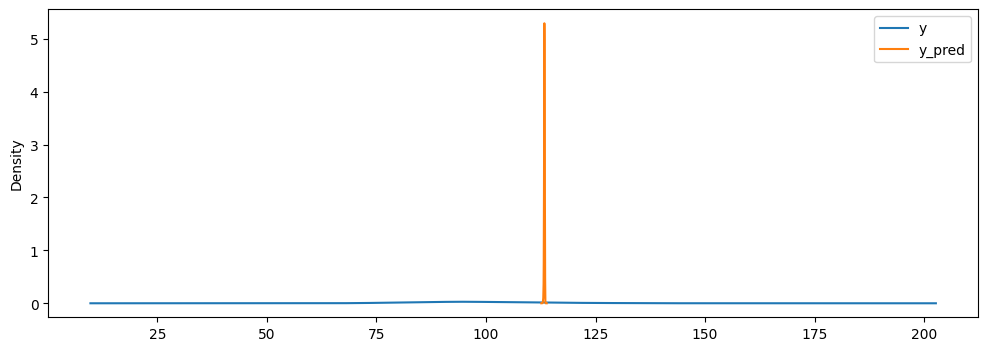

In [64]:
TSMixerx_result[['y','y_pred']].plot(kind='kde', figsize=(12,4))

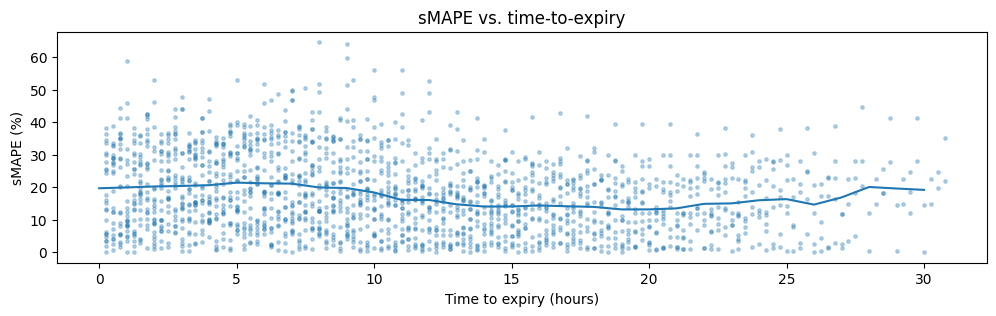

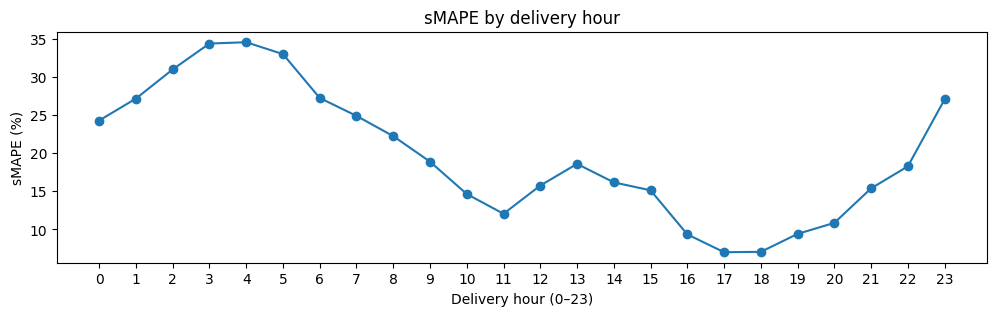

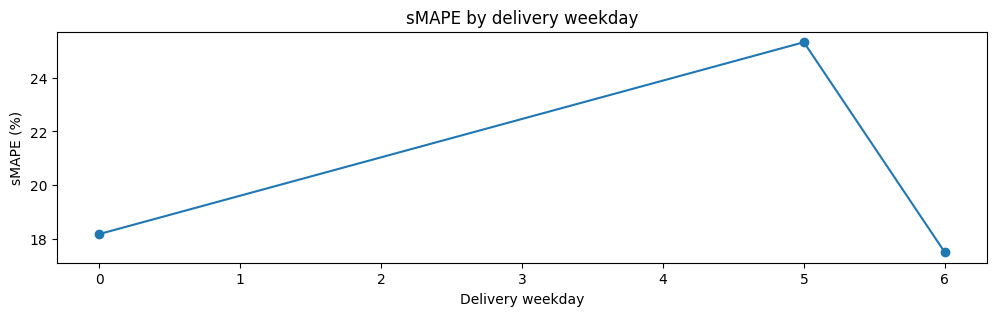

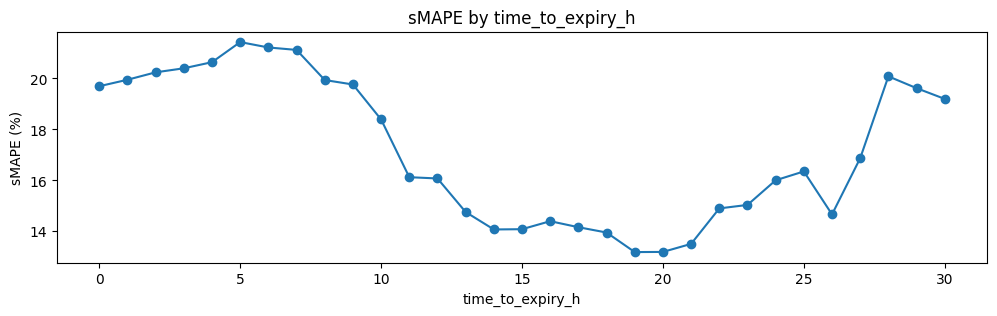

In [65]:
evaluation_plot(TSMixerx_result)

In [66]:
#TSMixerx_result.to_parquet('24hour_tsmixerx_result.parquet')

## Next hour prediction

In [67]:
nf_TSMixerx_hour, model_ts_hour = train_tsmixerx(
    train_f,
    static_train=None,
    futr_cols= None,
    hist_cols= None,
    static_cols = None,
    h = 1,
    input_size= 168,
    early_stop_patience_steps = 7
    )

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | loss                | MAE               | 0      | train
1 | valid_loss          | MAE               | 0      | train
2 | padder_train        | ConstantPad1d     | 0      | train
3 | scaler              | TemporalNorm      | 0      | train
4 | norm                | RevINMultivariate | 1.3 K  | train
5 | temporal_projection | Linear            | 169    | train
6 | feature_mixer_hist  | FeatureMixing     | 16.3 K | train
7 | first_mixing 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [68]:
forecast_df_TSMixerx_hour = nf_TSMixerx_hour.predict(futr_df=X_test, static_df = static_test)

/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.12/dist-packages/neuralforecast/core.py:940: UserWarning: Dropped 3,839,808 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: Fa

Predicting: |          | 0/? [00:00<?, ?it/s]

In [69]:
TSMixerx_result_hour = evaluation(forecast_df_TSMixerx_hour, test_actual)

smape: 21.625105784371463
mae: 21.595547389154273
rmse: 23.929354830483422


In [70]:
TSMixerx_result_hour, TSMixerx_result_group_hour = final_metric_comparison(TSMixerx_result_hour)

Average SMAPE: 21.62510578437147%
Min SMAPE: 0.2883954249559985%
Max SMAPE: 42.46267818619495%
Median SMAPE: 20.55764821185203%
Average MAE: 21.595547389154273
Min MAE: 0.32624190540946074
Max MAE: 39.67635197467722
Median MAE: 21.114160218558567


In [71]:
#TSMixerx_result_hour.to_parquet('TSMixerx_result_hour.parquet')

# TimesGPT

In [112]:
#pip install nixtla

In [73]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixak-dnHUeXG6rxM1MgXPTzXfxiRbvCgQChZsmffkflGarjHgfrKEwj954hNRDLlOByvEyCTEwJ7iNSszo7Qd'
)
nixtla_client.validate_api_key()

True

In [74]:
def evaluation_timegpt(timegpt_fcst_multiseries_df, test_actual=test_actual):

  forecast_cols = [c for c in timegpt_fcst_multiseries_df.columns if c not in ['unique_id','ds']]
  test_true = test_actual.copy()
  median=73.8
  scale=31.07534251

  merged = test_true.merge(
      timegpt_fcst_multiseries_df[['unique_id','ds'] + forecast_cols],
      on=['unique_id','ds'], how='inner')

  for col in forecast_cols:
      # inverse scaling
      Z = np.sinh(merged[col].to_numpy(dtype=float))
      y_pred = 2 * Z * scale + median

      y_true = merged['y'].to_numpy(dtype=float)

      # per-row sMAPE
      smape = 200 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)

      # attach back
      merged[col] = smape

  return merged


def evaluation_timegpt_conclusion(merged):
  merged_r = merged.copy()

  # which columns are model predictions
  model_cols = [c for c in merged_r.columns if c not in ['unique_id','ds','y','delivery_time']]

  def smape_vec(y_true, y_pred, eps=1e-8):
      return (200.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)).mean()

  # drop any rows with NaN in y or any model col (optional but safer)
  merged_r = merged_r.dropna(subset=['y'] + model_cols)

  rows = []
  for col in model_cols:
      y_true = merged_r['y'].to_numpy(dtype=float)
      y_pred = merged_r[col].to_numpy(dtype=float)
      rows.append([col, smape_vec(y_true, y_pred)])

  smape_table = pd.DataFrame(rows, columns=['model', 'sMAPE_%']).sort_values('sMAPE_%')
  return smape_table

## Next 24 Hour Prediction

In [75]:
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=train_f, h=24, freq='h', level=[80, 90])
timegpt_fcst_multiseries_df.head()

/usr/local/lib/python3.12/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['high', 'low', 'volume', 'price_range', 'q2h_price_diff', 'q2h_volume_diff', 'day_ahead_price', 'load_forecast', 'solar_forecast', 'wind_forecast', 'temperature_rounded', 'imported', 'exported', 'day_of_year_sin', 'day_of_year_cos', 'delivery_month_sin', 'delivery_month_cos', 'time_to_expiry_h', 'special_period', 'delivery_hour_sin', 'delivery_hour_cos', 'delivery_weekday_sin', 'delivery_weekday_cos', 'qh_sin', 'qh_cos', 'has_imported', 'has_exported', 'has_volume', 'has_q2h_volume_diff', 'has_data'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Fri00Q1,2024-01-06 21:00:00,0.003330,0.006659,0.006659,0.000000,0.000000
1,Fri00Q1,2024-01-06 22:00:00,0.001922,0.003844,0.003844,0.000000,0.000000
2,Fri00Q1,2024-01-06 23:00:00,0.000779,0.001558,0.001558,0.000000,0.000000
3,Fri00Q1,2024-01-07 00:00:00,-0.000064,0.000000,0.000000,-0.000127,-0.000127
4,Fri00Q1,2024-01-07 01:00:00,-0.000783,0.000000,0.000000,-0.001565,-0.001565


In [76]:
merged = evaluation_timegpt(  timegpt_fcst_multiseries_df, test_actual=test_actual)
merged.head()

,unique_id,ds,y,delivery_time,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Sat21Q2,2024-01-06 21:00:00,109.50,2024-01-06 21:15:00,38.683081,38.414229,38.414229,38.952537,38.952537
1,Sat21Q3,2024-01-06 21:00:00,88.05,2024-01-06 21:30:00,17.331030,17.053868,17.053868,17.608897,17.608897
2,Sat21Q4,2024-01-06 21:00:00,79.47,2024-01-06 21:45:00,7.119073,6.840189,6.840189,7.398708,7.398708
3,Sat22Q1,2024-01-06 21:00:00,106.02,2024-01-06 22:00:00,35.564754,35.294292,35.294292,35.835836,35.835836
4,Sat22Q2,2024-01-06 21:00:00,87.51,2024-01-06 22:15:00,16.720312,16.443007,16.443007,16.998326,16.998326


In [ ]:
merged = merged.drop(columns=['TimeGPT','TimeGPT-hi-80', 'TimeGPT-hi-90', 'TimeGPT-lo-90'])
merged = merged.rename(columns={'TimeGPT-lo-80':'y_pred'})

In [77]:
evaluation_timegpt_conclusion(merged)

,model,sMAPE_%
3,TimeGPT-lo-80,117.634214
4,TimeGPT-lo-90,117.634214
0,TimeGPT,118.069950
1,TimeGPT-hi-80,118.506085
2,TimeGPT-hi-90,118.506085


In [78]:
merged = merged.drop(columns=['TimeGPT','TimeGPT-hi-80', 'TimeGPT-hi-90', 'TimeGPT-lo-90'])
merged = merged.rename(columns={'TimeGPT-lo-80':'y_pred'})
timegpt_result, timegpt_result_group = final_metric_comparison(merged)

Average SMAPE: 117.6342139129913%
Min SMAPE: 74.089811313407%
Max SMAPE: 188.85269408994313%
Median SMAPE: 115.1245881045059%
Average MAE: 70.47026976531764
Min MAE: 46.693571888771444
Max MAE: 81.82229313247743
Median MAE: 70.30082931187836


In [79]:
timegpt_result.to_parquet('24hour_timegpt_result.parquet',index=False)

In [80]:
future_ex_vars_df_limited = train_f.drop(columns=hist_cols)
timegpt_fcst_ex_vars_df_limited = nixtla_client.forecast(df=train_f, h=24, level=[80,90], X_df=future_ex_vars_df_limited,hist_exog_list=hist_cols,
                                                          model='timegpt-1-long-horizon', freq='h', num_partitions=56)
timegpt_fcst_ex_vars_df_limited.head()

  0%|          | 0/56 [00:00<?, ?it/s]

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Fri00Q1,2024-01-06 21:00:00,0.000447,0.000700,0.000733,0.000194,0.000160
1,Fri00Q1,2024-01-06 22:00:00,0.000793,0.002138,0.002278,-0.000552,-0.000692
2,Fri00Q1,2024-01-06 23:00:00,0.001128,0.003261,0.003394,-0.001006,-0.001138
3,Fri00Q1,2024-01-07 00:00:00,0.000828,0.001895,0.001901,-0.000238,-0.000245
4,Fri00Q1,2024-01-07 01:00:00,0.001455,0.002374,0.002385,0.000536,0.000525


In [87]:
merged_p = evaluation_timegpt(timegpt_fcst_ex_vars_df_limited, test_actual=test_actual)
merged_p.head()

,unique_id,ds,y,delivery_time,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Sat21Q2,2024-01-06 21:00:00,109.50,2024-01-06 21:15:00,32.097440,31.981734,31.974815,32.213246,32.220177
1,Sat21Q3,2024-01-06 21:00:00,88.05,2024-01-06 21:30:00,12.340334,12.247775,12.237996,12.432967,12.442763
2,Sat21Q4,2024-01-06 21:00:00,79.47,2024-01-06 21:45:00,3.699697,3.635087,3.630668,3.764345,3.768770
3,Sat22Q1,2024-01-06 21:00:00,106.02,2024-01-06 22:00:00,27.550298,27.500823,27.497713,27.599792,27.602904
4,Sat22Q2,2024-01-06 21:00:00,87.51,2024-01-06 22:15:00,10.720784,10.582607,10.565465,10.859124,10.876309


In [82]:
evaluation_timegpt_conclusion(merged_p)

,model,sMAPE_%
4,TimeGPT-lo-90,121.496078
3,TimeGPT-lo-80,121.513656
0,TimeGPT,121.701128
1,TimeGPT-hi-80,121.888692
2,TimeGPT-hi-90,121.906269


In [88]:
merged_p = merged_p.drop(columns=['TimeGPT','TimeGPT-hi-80','TimeGPT-hi-90','TimeGPT-lo-80'])
merged_p = merged_p.rename(columns={'TimeGPT-lo-90':'y_pred'})

In [89]:
timegpt_lh_result, timegpt_lh_result_group = final_metric_comparison(merged_p)

Average SMAPE: 121.4960783548427%
Min SMAPE: 74.78745028968866%
Max SMAPE: 189.12065421630027%
Median SMAPE: 117.18911522975866%
Average MAE: 72.16137817632202
Min MAE: 46.54254338135059
Max MAE: 85.06636738468474
Median MAE: 71.51377394212696


In [90]:
#timegpt_lh_result.to_parquet('24hour_timegpt_lh_result.parquet',index=False)

## Next Hour Prediction

In [91]:
future_ex_vars_df_limited = train_f.drop(columns=hist_cols)
timegpt_fcst_ex_vars_df_limited_hour = nixtla_client.forecast(df=train_f, h=1, level=[80,90], freq='h')
timegpt_fcst_ex_vars_df_limited_hour.head()

/usr/local/lib/python3.12/dist-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['high', 'low', 'volume', 'price_range', 'q2h_price_diff', 'q2h_volume_diff', 'day_ahead_price', 'load_forecast', 'solar_forecast', 'wind_forecast', 'temperature_rounded', 'imported', 'exported', 'day_of_year_sin', 'day_of_year_cos', 'delivery_month_sin', 'delivery_month_cos', 'time_to_expiry_h', 'special_period', 'delivery_hour_sin', 'delivery_hour_cos', 'delivery_weekday_sin', 'delivery_weekday_cos', 'qh_sin', 'qh_cos', 'has_imported', 'has_exported', 'has_volume', 'has_q2h_volume_diff', 'has_data'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Fri00Q1,2024-01-06 21:00:00,0.00333,0.006659,0.006659,0.0,0.0
1,Fri00Q2,2024-01-06 21:00:00,0.00333,0.006659,0.006659,0.0,0.0
2,Fri00Q3,2024-01-06 21:00:00,0.00333,0.006659,0.006659,0.0,0.0
3,Fri00Q4,2024-01-06 21:00:00,0.00333,0.006659,0.006659,0.0,0.0
4,Fri01Q1,2024-01-06 21:00:00,0.00333,0.006659,0.006659,0.0,0.0


In [96]:
merged_p_hour = evaluation_timegpt(timegpt_fcst_ex_vars_df_limited_hour, test_actual=test_actual)
merged_p_hour.head()

,unique_id,ds,y,delivery_time,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Sat21Q2,2024-01-06 21:00:00,109.50,2024-01-06 21:15:00,38.683081,38.414229,38.414229,38.952537,38.952537
1,Sat21Q3,2024-01-06 21:00:00,88.05,2024-01-06 21:30:00,17.331030,17.053868,17.053868,17.608897,17.608897
2,Sat21Q4,2024-01-06 21:00:00,79.47,2024-01-06 21:45:00,7.119073,6.840189,6.840189,7.398708,7.398708
3,Sat22Q1,2024-01-06 21:00:00,106.02,2024-01-06 22:00:00,35.564754,35.294292,35.294292,35.835836,35.835836
4,Sat22Q2,2024-01-06 21:00:00,87.51,2024-01-06 22:15:00,16.720312,16.443007,16.443007,16.998326,16.998326


In [97]:
evaluation_timegpt_conclusion(merged_p_hour)

,model,sMAPE_%
3,TimeGPT-lo-80,130.590241
4,TimeGPT-lo-90,130.590241
0,TimeGPT,131.420955
1,TimeGPT-hi-80,132.254219
2,TimeGPT-hi-90,132.254219


In [98]:
merged_p_hour = merged_p_hour.drop(columns=['TimeGPT','TimeGPT-hi-80','TimeGPT-lo-90','TimeGPT-hi-90'])
merged_p_hour = merged_p_hour.rename(columns={'TimeGPT-lo-80':'y_pred'})
timegpt_hour_result, timegpt_hour_result_group = final_metric_comparison(merged_p_hour)

Average SMAPE: 130.59024076589566%
Min SMAPE: 89.71283147879859%
Max SMAPE: 198.53057863134856%
Median SMAPE: 122.58320031018994%
Average MAE: 70.76603726988809
Min MAE: 69.82774869274417
Max MAE: 73.35386165223278
Median MAE: 70.35800713827429


In [106]:
#timegpt_hour_result.to_parquet('timegpt_hour_result.parquet',index=False)

In [100]:
future_ex_vars_df_limited = train_f.drop(columns=hist_cols)
timegpt_fcst_ex_vars_df_limited_hour = nixtla_client.forecast(df=train_f, h=1, level=[80,90], X_df=future_ex_vars_df_limited,hist_exog_list=hist_cols,
                                                          model='timegpt-1-long-horizon', freq='h', num_partitions=56)
timegpt_fcst_ex_vars_df_limited_hour.head()

  0%|          | 0/56 [00:00<?, ?it/s]

ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out
ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out
ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out
ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Fri00Q1,2024-01-06 21:00:00,0.000447,0.000616,0.000644,0.000278,0.000249
1,Fri00Q2,2024-01-06 21:00:00,-0.004870,-0.004272,-0.004253,-0.005467,-0.005487
2,Fri00Q3,2024-01-06 21:00:00,-0.010110,-0.009989,-0.009975,-0.010232,-0.010246
3,Fri00Q4,2024-01-06 21:00:00,-0.014332,-0.014172,-0.014154,-0.014491,-0.014510
4,Fri01Q1,2024-01-06 21:00:00,-0.003869,-0.003594,-0.003537,-0.004143,-0.004200


In [101]:
merged_p_hour = evaluation_timegpt(timegpt_fcst_ex_vars_df_limited_hour, test_actual=test_actual)
merged_p_hour.head()

,unique_id,ds,y,delivery_time,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,Sat21Q2,2024-01-06 21:00:00,109.50,2024-01-06 21:15:00,32.097440,31.765593,31.752321,32.430113,32.443453
1,Sat21Q3,2024-01-06 21:00:00,88.05,2024-01-06 21:30:00,12.340334,12.265799,12.263334,12.414918,12.417385
2,Sat21Q4,2024-01-06 21:00:00,79.47,2024-01-06 21:45:00,3.699697,3.554340,3.551190,3.845250,3.848408
3,Sat22Q1,2024-01-06 21:00:00,106.02,2024-01-06 22:00:00,27.550298,27.467719,27.459275,27.632928,27.641383
4,Sat22Q2,2024-01-06 21:00:00,87.51,2024-01-06 22:15:00,10.720784,10.575622,10.566092,10.866126,10.875680


In [102]:
evaluation_timegpt_conclusion(merged_p_hour)

,model,sMAPE_%
4,TimeGPT-lo-90,133.409414
3,TimeGPT-lo-80,133.427819
0,TimeGPT,133.658818
1,TimeGPT-hi-80,133.890063
2,TimeGPT-hi-90,133.908506


In [103]:
merged_p_hour = merged_p_hour.drop(columns=['TimeGPT','TimeGPT-hi-80','TimeGPT-lo-80','TimeGPT-hi-90'])
merged_p_hour = merged_p_hour.rename(columns={'TimeGPT-lo-90':'y_pred'})
timegpt_lh_hour_result, timegpt_lh_hour_result_group = final_metric_comparison(merged_p_hour)

Average SMAPE: 133.40941388745594%
Min SMAPE: 85.37011598413525%
Max SMAPE: 192.87363243843117%
Median SMAPE: 129.79542593422818%
Average MAE: 71.94868694999549
Min MAE: 67.25138440244183
Max MAE: 80.96873876865486
Median MAE: 71.58771961062415


In [105]:
#timegpt_lh_hour_result.to_parquet('timegpt_lh_hour_result.parquet')

# Performence Analysis

In [45]:
from typing import Dict, Literal, Optional
import plotly.express as px


def _ensure_dt(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['delivery_time'].dtype, np.datetime64):
        df['delivery_time'] = pd.to_datetime(df['delivery_time'])
    if not np.issubdtype(df['ds'].dtype, np.datetime64):
        df['ds'] = pd.to_datetime(df['ds'])
    return df


def _add_group_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['delivery_hour'] = df['delivery_time'].dt.hour
    minutes = df['delivery_time'].dt.minute
    df['quarter_hour'] = (minutes // 15) * 15
    df['time_to_expiry_h'] = ((df['delivery_time'] - df['ds']).dt.total_seconds() / 3600.0).astype(int)
    month = df['delivery_time'].dt.month
    df['season'] = month.map(lambda x: (
        "Spring" if x in [3,4,5] else
        "Summer" if x in [6,7,8] else
        "Autumn" if x in [9,10,11] else
        "Winter"
    ))
    return df


def _prepare_long_df(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    dfs = []
    for name, d in models.items():
        dd = _ensure_dt(d)
        dd = _add_group_columns(dd)
        dd = dd.copy()
        dd['model'] = name
        dfs.append(dd)
    return pd.concat(dfs, ignore_index=True)

# -------------------- main plot function --------------------

def plot_model_metric_plotly(
    models: Dict[str, pd.DataFrame],
    metric: Literal['smape','mae'] = 'smape',
    groupby: Literal['delivery_hour','quarter_hour','season','time_to_expiry_h'] = 'delivery_hour',
    agg: Literal['median','mean'] = 'median',
    sort_x: bool = True,
    template: str = 'plotly_white',
    height: Optional[int] = 500,
    width: Optional[int] = None,
    markers: bool = True,
    title: Optional[str] = None,
) -> pd.DataFrame:
    """
    Plotly line plot：compare different models' performences(smape, mae) under different group(delivery_hour, quarter_hour, season, time_to_expiry)
    """
    long_df = _prepare_long_df(models)
    grp = long_df.groupby([groupby, 'model'], dropna=False)[metric]

    # choose mean or median
    if agg == 'mean':
        stats = grp.mean().reset_index(name='center')
    else:
        stats = grp.median().reset_index(name='center')

    pivot_df = stats.pivot(index=groupby, columns='model', values='center')

    category_orders = None
    if groupby == 'season' and sort_x:
        category_orders = {groupby: ['Spring','Summer','Autumn','Winter']}
    elif sort_x:
        stats = stats.sort_values(by=groupby)

    fig = px.line(
        stats,
        x=groupby,
        y='center',
        color='model',
        markers=markers,
        category_orders=category_orders,
        title=title or f"{('MEDIAN' if agg=='median' else 'MEAN')} {metric.upper()} by {groupby} for Next 24 Hours Prediction",
        template=template,
    )

    fig.update_layout(
        xaxis_title=groupby,
        yaxis_title=metric,
        height=400,
        width=1000,
        legend_title_text='model',
    )

    fig.show()
    return pivot_df


## Next Hour

In [47]:
models = {'NBEATSx': nbeatsx_m_hour, 'TSMixerx': TSMixerx_result_hour, 'TimeGPT': timegpt_hour_result,'TimeGPT_lh': timegpt_lh_hour_result}

delivery_hour_smape_hour = plot_model_metric_plotly(models,agg='mean', metric='smape', groupby='delivery_hour', template='plotly_white')

In [49]:
time_to_expiry_smape_hour =  plot_model_metric_plotly(models,agg='mean', metric='smape', groupby='time_to_expiry_h', template='plotly_white')

## Next 24 Hours

In [50]:
models = {'NBEATSx': nbeatsx_m, 'TSMixerx': TSMixerx_result, 'TimeGPT': timegpt_result,'TimeGPT_lh': timegpt_lh_result}

delivery_hour_smape_24hour  = plot_model_metric_plotly(models,agg='mean', metric='smape', groupby='delivery_hour', template='plotly_white')

In [51]:
models = {'NBEATSx': nbeatsx_m, 'TSMixerx': TSMixerx_result, 'TimeGPT': timegpt_result,'TimeGPT_lh': timegpt_lh_result}

time_to_expiry_smape_24hour = plot_model_metric_plotly(models,agg='mean', metric='smape', groupby='time_to_expiry_h', template='plotly_white')